In [1]:
import os
import warnings

import gymnasium as gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PlotRenderer
from gym_trading.envs.rewards import ProfitRewarder, OneStepProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_top_ranked_cryptos(n):
    url = f"https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=market_cap_desc&per_page={n}&page=1&sparkline=false"

    response = requests.get(url)
    data = response.json()

    top_cryptos = []
    for crypto in data:
        # print(crypto)
        top_cryptos.append(crypto['id'])

    return top_cryptos

In [3]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

In [4]:
N_DAYS = 365 * 3
SAVE_DIR = "crypto_datasets__days-" + str(N_DAYS)

In [5]:
def save_datasets(datasets, days):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    for symbol, df in datasets.items():
        filename = f"{symbol}_{days}_days.csv"
        file_path = os.path.join(SAVE_DIR, filename)
        df.to_csv(file_path, index=False)
        print(f"Saved {symbol} dataset to {file_path}")
        
def load_datasets():
    datasets = {}
    try:
        for file in os.listdir(SAVE_DIR):
            if file.endswith(".csv"):
                symbol, days, _ = file.split("_")
                days = int(days)
                file_path = os.path.join(SAVE_DIR, file)
                df = pd.read_csv(file_path)
                datasets[symbol] = df
    except FileNotFoundError:
        return datasets
    return datasets

In [6]:
datasets = load_datasets()

if len(datasets.keys()) == 0:
    print('downloading new data')
    
    top_cryptos = get_top_ranked_cryptos(10)
    print('Downloading datasets for top cryptos: {top_cryptos}')
    
    df = pd.DataFrame()

    for symbol in top_cryptos:
        df = get_symbol_history(symbol, N_DAYS)

        # removing the last row since sometimes are not aligned
        df.drop(df.index[-1], inplace=True)

        datasets[symbol] = df
        
    save_datasets(datasets, N_DAYS)

In [7]:
for symbol, df in datasets.items():
    df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Removing stable coins and crypto with less days than expected
del datasets['staked-ether']
del datasets['tether']
del datasets['usd-coin']
# del datasets['solana']

In [9]:
df = list(datasets.values())[0]
df['Date'].iloc[1] - df['Date'].iloc[0]

Timedelta('1 days 00:00:00')

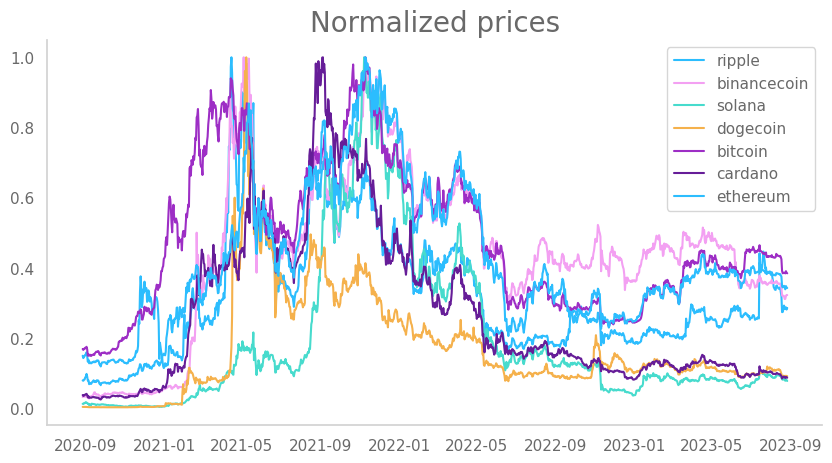

In [10]:
for symbol, df in datasets.items():
    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)

plt.title('Normalized prices')
plt.legend()
plt.show()

In [11]:
SYMBOLS = list(datasets.keys())
SYMBOLS

['ripple',
 'binancecoin',
 'solana',
 'dogecoin',
 'bitcoin',
 'cardano',
 'ethereum']

In [12]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    return train_df, valid_df, test_df

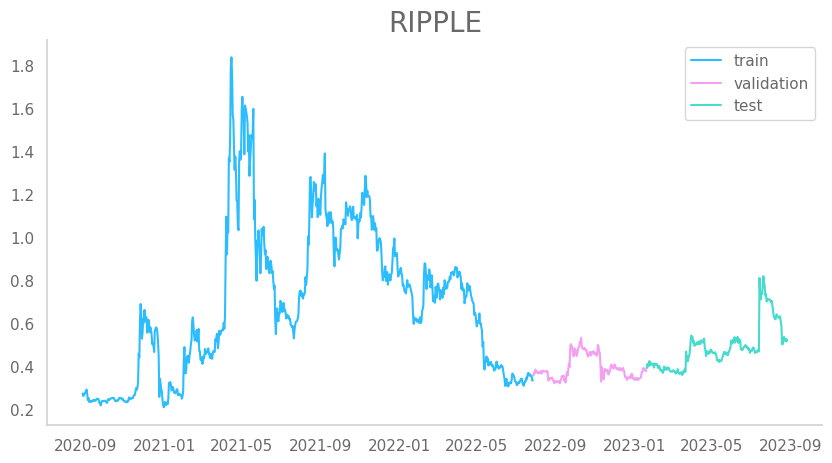

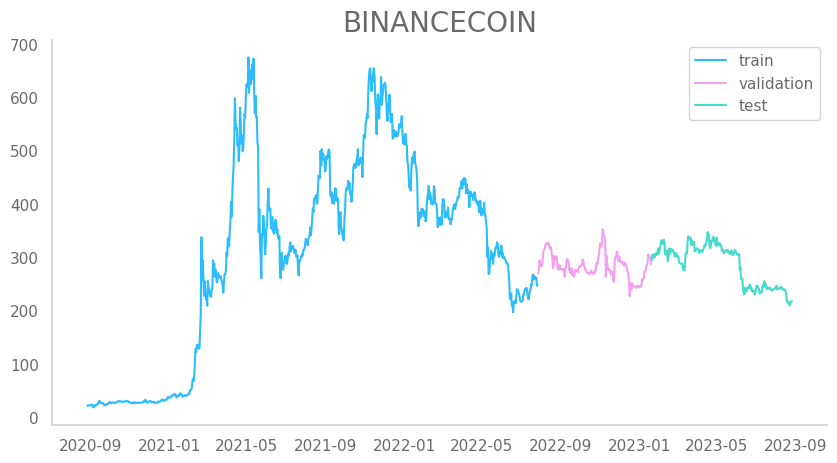

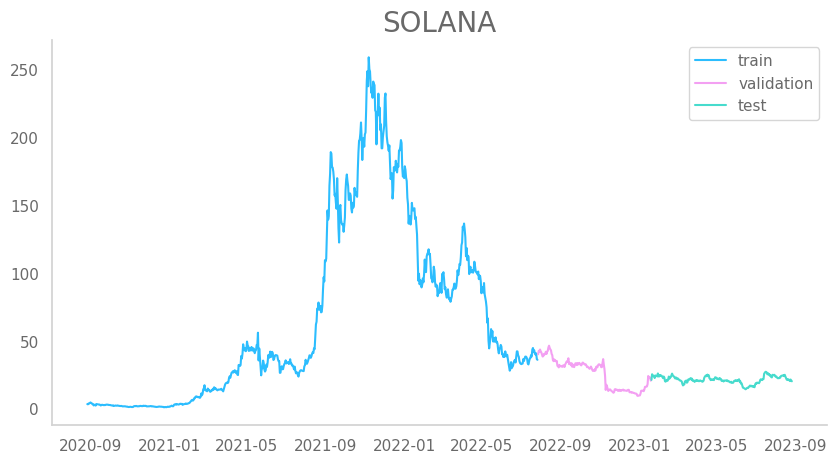

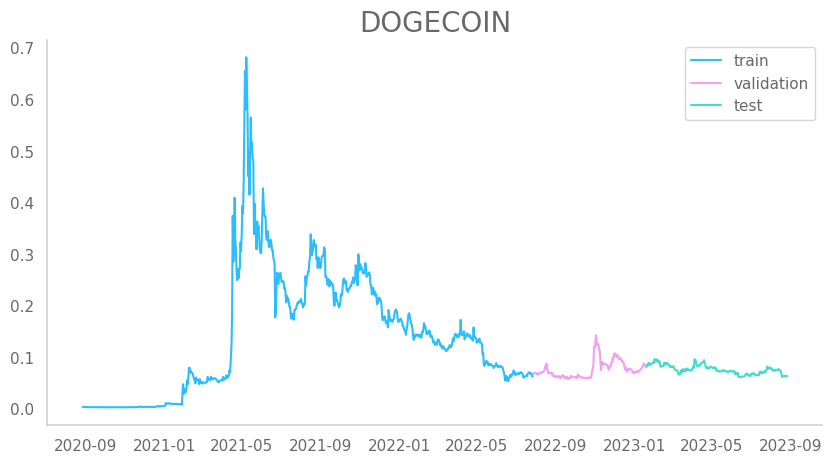

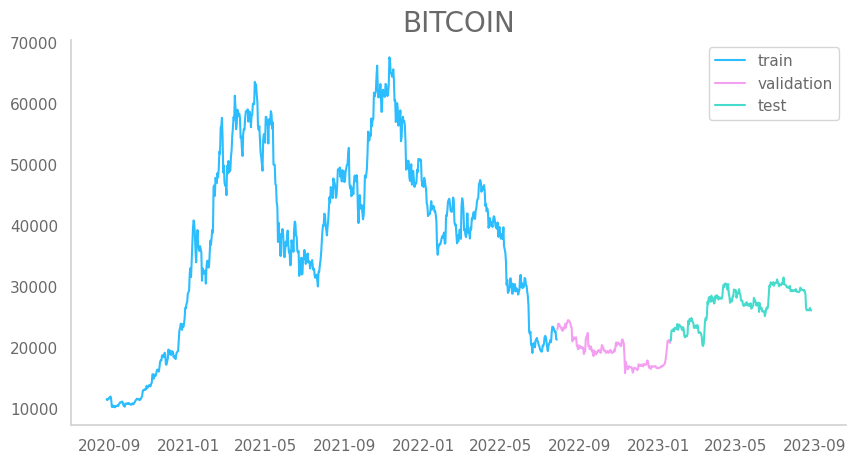

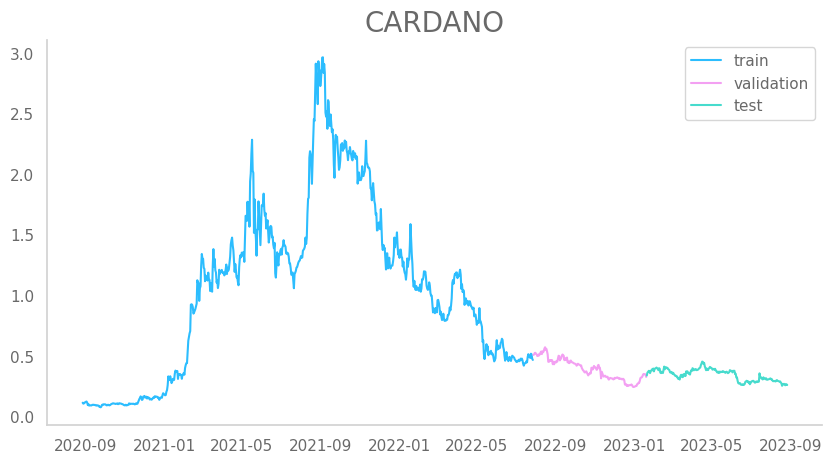

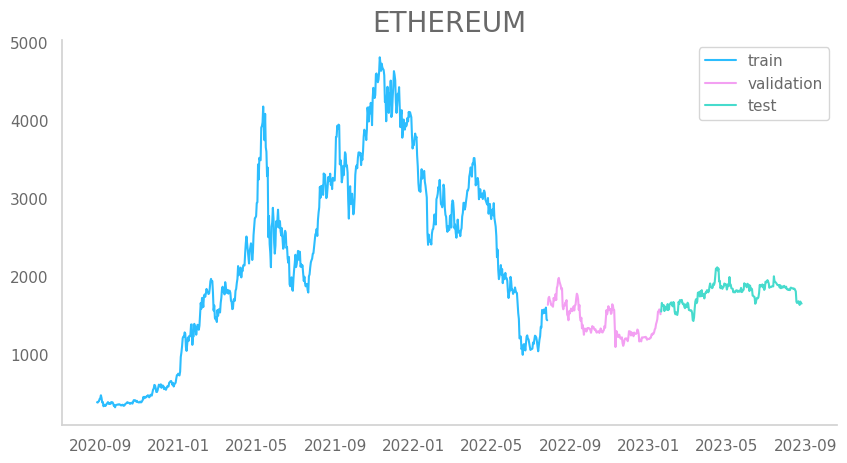

In [13]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

In [14]:
INIT_LIQUIDITY = 100.0
BUY_FEE = 0.1
SELL_FEE = 0.1

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PlotRenderer(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=OneStepProfitRewarder(),
    renderer=PlotRenderer(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),  # ProfitRewarder: to compute the reward overall the simulation
    renderer=PlotRenderer(),
)

In [15]:
observation = train_env.reset()[0]
observation

array([[2.7651089e-01, 1.2444059e+10, 1.7222977e+09, 2.2225939e+01,
        3.2956972e+09, 2.6582914e+08, 3.5510669e+00, 1.1421914e+08,
        2.2112806e+07, 3.2884367e-03, 4.1432208e+08, 1.7073408e+08,
        1.1465003e+04, 2.1177895e+11, 2.0869929e+10, 1.1446062e-01,
        3.5614497e+09, 4.4852237e+08, 3.8575250e+02, 4.3337732e+10,
        1.0454042e+10]], dtype=float32)

In [16]:
observation.shape

(1, 21)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Preprocessor():
    
    def __init__(self, window_size=2):
        self.ws = window_size
        self.buffer = []

    def preprocess(self, observation):
        self.buffer.append(observation)
        
        if len(self.buffer) > self.ws:
            self.buffer.pop(0)
        
        while len(self.buffer) < self.ws:
            self.buffer.insert(0, np.zeros_like(observation))
        
        stacked_data = np.vstack(self.buffer)
        return StandardScaler().fit_transform(stacked_data)

In [18]:
processor = Preprocessor()
processor.preprocess(observation).shape

(2, 21)

In [19]:
from typing import List, Any, Tuple, SupportsFloat
from gymnasium.experimental.functional import ObsType
from gymnasium.core import ActType
from gymnasium.spaces import Box

class GymWrapper(gym.Env):
    
    def __init__(self, env):
        super(GymWrapper, self).__init__()
        
        self.processor = Preprocessor()
        
        self.env = env
        self.action_space = env.action_space
        self.observation_space = Box(
            low=-np.inf, 
            high=np.inf, 
            shape=self.processor.preprocess(np.zeros(self.env.observation_space.shape)).shape
        )
        
    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict[str, Any] | None = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        observation, info = self.env.reset()
        self.processor = Preprocessor()
        return self.processor.preprocess(observation), info

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        observation, reward, done, truncated, info = self.env.step(action)
        observation = self.processor.preprocess(observation)
        return observation, reward, done, truncated, info

In [20]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, StackedObservations

# Creating and wrapping the environments
train_vec_env = SubprocVecEnv([lambda: GymWrapper(train_env)] * 8)

valid_vec_env = DummyVecEnv([lambda: GymWrapper(valid_env)])
test_vec_env = DummyVecEnv([lambda: GymWrapper(test_env)])

In [21]:
def evaluate(model, vec_env):
    mean_reward, std_reward = evaluate_policy(
        model,
        vec_env, 
        n_eval_episodes=1,
        deterministic=True,
        render=False
    )
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [22]:
log_dir = './logs/'
time_steps = 500_000

In [23]:
from sb3_contrib import RecurrentPPO

model = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=train_vec_env,
    verbose=1,
    tensorboard_log=log_dir,
)

Using cuda device


In [24]:
print('Evaluate on test vec env before training')
evaluate(model, test_vec_env)

Evaluate on test vec env before training
Mean reward: -7.02 +/- 0.00


In [25]:
eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=int(time_steps),
    callback=callbacks,
    progress_bar=True
)

Logging to ./logs/RecurrentPPO_1


Output()

-----------------------------
| time/              |      |
|    fps             | 248  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0065223263 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.95        |
|    explained_variance   | 0.00115      |
|    learning_rate        | 0.0003       |
|    loss                 | 22.4         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0102      |
|    std                  | 1            |
|    value_loss           | 67.7         |
----------------

Eval num_timesteps=8000, episode_reward=2.89 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 2.89        |
| time/                   |             |
|    total_timesteps      | 8000        |
| train/                  |             |
|    approx_kl            | 0.007136752 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.94       |
|    explained_variance   | -0.00906    |
|    learning_rate        | 0.0003      |
|    loss                 | 138         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00942    |
|    std                  | 1           |
|    value_loss           | 561         |
-----------------------------------------


New best mean reward!

-----------------------------
| time/              |      |
|    fps             | 153  |
|    iterations      | 8    |
|    time_elapsed    | 53   |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 157        |
|    iterations           | 9          |
|    time_elapsed         | 58         |
|    total_timesteps      | 9216       |
| train/                  |            |
|    approx_kl            | 0.00799523 |
|    clip_fraction        | 0.0543     |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.93      |
|    explained_variance   | -0.0461    |
|    learning_rate        | 0.0003     |
|    loss                 | 90.2       |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.0146    |
|    std                  | 0.999      |
|    value_loss           | 150        |
----------------------------------------
-----------

Eval num_timesteps=16000, episode_reward=-4.13 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -4.13       |
| time/                   |             |
|    total_timesteps      | 16000       |
| train/                  |             |
|    approx_kl            | 0.008427527 |
|    clip_fraction        | 0.0636      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.8        |
|    explained_variance   | 0.00182     |
|    learning_rate        | 0.0003      |
|    loss                 | 18.4        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0144     |
|    std                  | 0.982       |
|    value_loss           | 63.9        |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 156   |
|    iterations      | 16    |
|    time_elapsed    | 104   |
|    total_timesteps | 16384 |
----------------

Eval num_timesteps=24000, episode_reward=1.56 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 1.56        |
| time/                   |             |
|    total_timesteps      | 24000       |
| train/                  |             |
|    approx_kl            | 0.008261793 |
|    clip_fraction        | 0.0595      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.78       |
|    explained_variance   | 0.41        |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0163     |
|    std                  | 0.978       |
|    value_loss           | 140         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 155   |
|    iterations      | 24    |
|    time_elapsed    | 157   |
|    total_timesteps | 24576 |
----------------

Eval num_timesteps=32000, episode_reward=12.80 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 12.8        |
| time/                   |             |
|    total_timesteps      | 32000       |
| train/                  |             |
|    approx_kl            | 0.012557635 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.76       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.1        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0186     |
|    std                  | 0.975       |
|    value_loss           | 60          |
-----------------------------------------


New best mean reward!

------------------------------
| time/              |       |
|    fps             | 157   |
|    iterations      | 32    |
|    time_elapsed    | 207   |
|    total_timesteps | 32768 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 33          |
|    time_elapsed         | 212         |
|    total_timesteps      | 33792       |
| train/                  |             |
|    approx_kl            | 0.011094043 |
|    clip_fraction        | 0.0833      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.75       |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.37        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.972       |
|    value_loss           | 22.8        |
---------------------------

Eval num_timesteps=40000, episode_reward=-3.01 +/- 0.00

Episode length: 176.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 176          |
|    mean_reward          | -3.01        |
| time/                   |              |
|    total_timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0097052185 |
|    clip_fraction        | 0.0833       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.69        |
|    explained_variance   | 0.483        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.0189      |
|    std                  | 0.963        |
|    value_loss           | 31.8         |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 155   |
|    iterations      | 40    |
|    time_elapsed    | 263   |
|    total_timesteps | 40960

Eval num_timesteps=48000, episode_reward=-25.91 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -25.9       |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.011986231 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.58       |
|    explained_variance   | 0.408       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.2        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0201     |
|    std                  | 0.952       |
|    value_loss           | 248         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 156   |
|    iterations      | 47    |
|    time_elapsed    | 307   |
|    total_timesteps | 48128 |
----------------

Eval num_timesteps=56000, episode_reward=-30.56 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -30.6       |
| time/                   |             |
|    total_timesteps      | 56000       |
| train/                  |             |
|    approx_kl            | 0.017142223 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.6        |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.86        |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.0278     |
|    std                  | 0.953       |
|    value_loss           | 21.3        |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 156   |
|    iterations      | 55    |
|    time_elapsed    | 358   |
|    total_timesteps | 56320 |
----------------

Eval num_timesteps=64000, episode_reward=-25.30 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -25.3       |
| time/                   |             |
|    total_timesteps      | 64000       |
| train/                  |             |
|    approx_kl            | 0.011760087 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.57       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | 227         |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.0238     |
|    std                  | 0.949       |
|    value_loss           | 468         |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 155   |
|    iterations      | 63    |
|    time_elapsed    | 414   |
|    total_timesteps | 64512 |
----------------

Eval num_timesteps=72000, episode_reward=-18.95 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -19         |
| time/                   |             |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.015572125 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.5        |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0281     |
|    std                  | 0.941       |
|    value_loss           | 28.7        |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 156   |
|    iterations      | 71    |
|    time_elapsed    | 463   |
|    total_timesteps | 72704 |
----------------

Eval num_timesteps=80000, episode_reward=1.15 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 1.15        |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.015095954 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.4        |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.9        |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.0234     |
|    std                  | 0.927       |
|    value_loss           | 1.08e+03    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 156   |
|    iterations      | 79    |
|    time_elapsed    | 518   |
|    total_timesteps | 80896 |
----------------

Eval num_timesteps=88000, episode_reward=3.11 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 3.11        |
| time/                   |             |
|    total_timesteps      | 88000       |
| train/                  |             |
|    approx_kl            | 0.015210679 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.36       |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 72          |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.0267     |
|    std                  | 0.922       |
|    value_loss           | 77.3        |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 155   |
|    iterations      | 86    |
|    time_elapsed    | 566   |
|    total_timesteps | 88064 |
----------------

Eval num_timesteps=96000, episode_reward=-25.53 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -25.5       |
| time/                   |             |
|    total_timesteps      | 96000       |
| train/                  |             |
|    approx_kl            | 0.015415514 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.36       |
|    explained_variance   | 0.701       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.2        |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.028      |
|    std                  | 0.923       |
|    value_loss           | 35.3        |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 154   |
|    iterations      | 94    |
|    time_elapsed    | 621   |
|    total_timesteps | 96256 |
----------------

Eval num_timesteps=104000, episode_reward=-20.16 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -20.2       |
| time/                   |             |
|    total_timesteps      | 104000      |
| train/                  |             |
|    approx_kl            | 0.013957277 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.32       |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.0264     |
|    std                  | 0.916       |
|    value_loss           | 71.7        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 155    |
|    iterations      | 102    |
|    time_elapsed    | 672    |
|    total_timesteps | 104448 |
----------

Eval num_timesteps=112000, episode_reward=-45.66 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -45.7      |
| time/                   |            |
|    total_timesteps      | 112000     |
| train/                  |            |
|    approx_kl            | 0.01887886 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.3       |
|    explained_variance   | 0.712      |
|    learning_rate        | 0.0003     |
|    loss                 | 15.5       |
|    n_updates            | 1090       |
|    policy_gradient_loss | -0.0315    |
|    std                  | 0.914      |
|    value_loss           | 27.1       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 155    |
|    iterations      | 110    |
|    time_elapsed    | 724    |
|    total_timesteps | 112640 |
-----------------------------

Eval num_timesteps=120000, episode_reward=-8.29 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -8.29       |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.014958834 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.25       |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.6        |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.0273     |
|    std                  | 0.907       |
|    value_loss           | 266         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 118    |
|    time_elapsed    | 780    |
|    total_timesteps | 120832 |
----------

Eval num_timesteps=128000, episode_reward=-42.62 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -42.6       |
| time/                   |             |
|    total_timesteps      | 128000      |
| train/                  |             |
|    approx_kl            | 0.020846456 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.18       |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.0359     |
|    std                  | 0.898       |
|    value_loss           | 28.8        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 125    |
|    time_elapsed    | 826    |
|    total_timesteps | 128000 |
----------

Eval num_timesteps=136000, episode_reward=-28.10 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -28.1      |
| time/                   |            |
|    total_timesteps      | 136000     |
| train/                  |            |
|    approx_kl            | 0.01965289 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.1       |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.1       |
|    n_updates            | 1320       |
|    policy_gradient_loss | -0.0398    |
|    std                  | 0.888      |
|    value_loss           | 46.9       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 133    |
|    time_elapsed    | 881    |
|    total_timesteps | 136192 |
-----------------------------

Eval num_timesteps=144000, episode_reward=-34.07 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -34.1      |
| time/                   |            |
|    total_timesteps      | 144000     |
| train/                  |            |
|    approx_kl            | 0.01914417 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.99      |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.0003     |
|    loss                 | 11.2       |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.034     |
|    std                  | 0.874      |
|    value_loss           | 51.7       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 141    |
|    time_elapsed    | 933    |
|    total_timesteps | 144384 |
-----------------------------

Eval num_timesteps=152000, episode_reward=10.92 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 10.9       |
| time/                   |            |
|    total_timesteps      | 152000     |
| train/                  |            |
|    approx_kl            | 0.03110591 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.93      |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.2       |
|    n_updates            | 1480       |
|    policy_gradient_loss | -0.0436    |
|    std                  | 0.867      |
|    value_loss           | 25.7       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 149    |
|    time_elapsed    | 990    |
|    total_timesteps | 152576 |
-----------------------------

Eval num_timesteps=160000, episode_reward=7.99 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 7.99        |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.022261342 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.89       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.7        |
|    n_updates            | 1560        |
|    policy_gradient_loss | -0.0427     |
|    std                  | 0.863       |
|    value_loss           | 56.2        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 157    |
|    time_elapsed    | 1040   |
|    total_timesteps | 160768 |
----------

Eval num_timesteps=168000, episode_reward=-10.36 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -10.4       |
| time/                   |             |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.033148874 |
|    clip_fraction        | 0.335       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.75       |
|    explained_variance   | 0.711       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.8        |
|    n_updates            | 1640        |
|    policy_gradient_loss | -0.0468     |
|    std                  | 0.845       |
|    value_loss           | 24.9        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 165    |
|    time_elapsed    | 1090   |
|    total_timesteps | 168960 |
----------

Eval num_timesteps=176000, episode_reward=19.96 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 20         |
| time/                   |            |
|    total_timesteps      | 176000     |
| train/                  |            |
|    approx_kl            | 0.02401034 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.69      |
|    explained_variance   | 0.531      |
|    learning_rate        | 0.0003     |
|    loss                 | 236        |
|    n_updates            | 1710       |
|    policy_gradient_loss | -0.0365    |
|    std                  | 0.837      |
|    value_loss           | 612        |
----------------------------------------


New best mean reward!

-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 172    |
|    time_elapsed    | 1140   |
|    total_timesteps | 176128 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 173         |
|    time_elapsed         | 1145        |
|    total_timesteps      | 177152      |
| train/                  |             |
|    approx_kl            | 0.022503968 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.66       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.3        |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.0457     |
|    std                  | 0.834       |
|    value_loss           | 71.7        |
--------------------

Eval num_timesteps=184000, episode_reward=-22.99 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -23        |
| time/                   |            |
|    total_timesteps      | 184000     |
| train/                  |            |
|    approx_kl            | 0.03222386 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.59      |
|    explained_variance   | 0.723      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.1       |
|    n_updates            | 1790       |
|    policy_gradient_loss | -0.0446    |
|    std                  | 0.826      |
|    value_loss           | 21.3       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 180    |
|    time_elapsed    | 1191   |
|    total_timesteps | 184320 |
-----------------------------

Eval num_timesteps=192000, episode_reward=-40.09 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -40.1      |
| time/                   |            |
|    total_timesteps      | 192000     |
| train/                  |            |
|    approx_kl            | 0.04031533 |
|    clip_fraction        | 0.332      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.49      |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.0003     |
|    loss                 | 42         |
|    n_updates            | 1870       |
|    policy_gradient_loss | -0.0452    |
|    std                  | 0.817      |
|    value_loss           | 130        |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 188    |
|    time_elapsed    | 1246   |
|    total_timesteps | 192512 |
-----------------------------

Eval num_timesteps=200000, episode_reward=-19.56 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -19.6       |
| time/                   |             |
|    total_timesteps      | 200000      |
| train/                  |             |
|    approx_kl            | 0.022732798 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.49       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.0435     |
|    std                  | 0.816       |
|    value_loss           | 35.4        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 196    |
|    time_elapsed    | 1296   |
|    total_timesteps | 200704 |
----------

Eval num_timesteps=208000, episode_reward=-16.80 +/- 0.00

Episode length: 176.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 176       |
|    mean_reward          | -16.8     |
| time/                   |           |
|    total_timesteps      | 208000    |
| train/                  |           |
|    approx_kl            | 0.0314899 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.38     |
|    explained_variance   | 0.948     |
|    learning_rate        | 0.0003    |
|    loss                 | 21.4      |
|    n_updates            | 2030      |
|    policy_gradient_loss | -0.0453   |
|    std                  | 0.803     |
|    value_loss           | 45        |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 204    |
|    time_elapsed    | 1353   |
|    total_timesteps | 208896 |
-------------------------------
----------------

Eval num_timesteps=216000, episode_reward=-19.07 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -19.1       |
| time/                   |             |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.021685291 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.27       |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 310         |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.035      |
|    std                  | 0.791       |
|    value_loss           | 383         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 211    |
|    time_elapsed    | 1397   |
|    total_timesteps | 216064 |
----------

Eval num_timesteps=224000, episode_reward=-37.43 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -37.4       |
| time/                   |             |
|    total_timesteps      | 224000      |
| train/                  |             |
|    approx_kl            | 0.049822822 |
|    clip_fraction        | 0.396       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.2        |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.85        |
|    n_updates            | 2180        |
|    policy_gradient_loss | -0.0529     |
|    std                  | 0.782       |
|    value_loss           | 19.9        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 219    |
|    time_elapsed    | 1448   |
|    total_timesteps | 224256 |
----------

Eval num_timesteps=232000, episode_reward=-43.67 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -43.7       |
| time/                   |             |
|    total_timesteps      | 232000      |
| train/                  |             |
|    approx_kl            | 0.032644894 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.11       |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.3        |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0523     |
|    std                  | 0.772       |
|    value_loss           | 309         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 227    |
|    time_elapsed    | 1503   |
|    total_timesteps | 232448 |
----------

Eval num_timesteps=240000, episode_reward=-25.06 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -25.1      |
| time/                   |            |
|    total_timesteps      | 240000     |
| train/                  |            |
|    approx_kl            | 0.04779969 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.01      |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.55       |
|    n_updates            | 2340       |
|    policy_gradient_loss | -0.0451    |
|    std                  | 0.762      |
|    value_loss           | 21.3       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 235    |
|    time_elapsed    | 1553   |
|    total_timesteps | 240640 |
-----------------------------

Eval num_timesteps=248000, episode_reward=-14.97 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -15         |
| time/                   |             |
|    total_timesteps      | 248000      |
| train/                  |             |
|    approx_kl            | 0.038250603 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.89       |
|    explained_variance   | 0.341       |
|    learning_rate        | 0.0003      |
|    loss                 | 919         |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.05       |
|    std                  | 0.748       |
|    value_loss           | 1.71e+03    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 243    |
|    time_elapsed    | 1608   |
|    total_timesteps | 248832 |
----------

Eval num_timesteps=256000, episode_reward=19.93 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 19.9        |
| time/                   |             |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.039564885 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.8        |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.0003      |
|    loss                 | 40.2        |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.0569     |
|    std                  | 0.739       |
|    value_loss           | 42          |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 250    |
|    time_elapsed    | 1654   |
|    total_timesteps | 256000 |
----------

Eval num_timesteps=264000, episode_reward=-27.24 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -27.2      |
| time/                   |            |
|    total_timesteps      | 264000     |
| train/                  |            |
|    approx_kl            | 0.07896462 |
|    clip_fraction        | 0.462      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.75      |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.0003     |
|    loss                 | 27.4       |
|    n_updates            | 2570       |
|    policy_gradient_loss | -0.047     |
|    std                  | 0.735      |
|    value_loss           | 23.9       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 258    |
|    time_elapsed    | 1704   |
|    total_timesteps | 264192 |
-----------------------------

Eval num_timesteps=272000, episode_reward=9.25 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 9.25        |
| time/                   |             |
|    total_timesteps      | 272000      |
| train/                  |             |
|    approx_kl            | 0.026115999 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.69       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.0003      |
|    loss                 | 81.4        |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.0444     |
|    std                  | 0.728       |
|    value_loss           | 105         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 266    |
|    time_elapsed    | 1760   |
|    total_timesteps | 272384 |
----------

Eval num_timesteps=280000, episode_reward=31.54 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 31.5       |
| time/                   |            |
|    total_timesteps      | 280000     |
| train/                  |            |
|    approx_kl            | 0.05182998 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.68      |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.29       |
|    n_updates            | 2730       |
|    policy_gradient_loss | -0.05      |
|    std                  | 0.728      |
|    value_loss           | 23.7       |
----------------------------------------


New best mean reward!

-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 274    |
|    time_elapsed    | 1812   |
|    total_timesteps | 280576 |
-------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 154        |
|    iterations           | 275        |
|    time_elapsed         | 1821       |
|    total_timesteps      | 281600     |
| train/                  |            |
|    approx_kl            | 0.05133721 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.66      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | 16         |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0534    |
|    std                  | 0.725      |
|    value_loss           | 27.9       |
--------------------------------------

Eval num_timesteps=288000, episode_reward=17.38 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 17.4        |
| time/                   |             |
|    total_timesteps      | 288000      |
| train/                  |             |
|    approx_kl            | 0.025089504 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.61       |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 74.4        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.0429     |
|    std                  | 0.72        |
|    value_loss           | 547         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 282    |
|    time_elapsed    | 1868   |
|    total_timesteps | 288768 |
----------

Eval num_timesteps=296000, episode_reward=-12.37 +/- 0.00

Episode length: 176.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 176       |
|    mean_reward          | -12.4     |
| time/                   |           |
|    total_timesteps      | 296000    |
| train/                  |           |
|    approx_kl            | 0.1334638 |
|    clip_fraction        | 0.466     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.55     |
|    explained_variance   | 0.686     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.91      |
|    n_updates            | 2890      |
|    policy_gradient_loss | -0.0601   |
|    std                  | 0.713     |
|    value_loss           | 21.8      |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 290    |
|    time_elapsed    | 1918   |
|    total_timesteps | 296960 |
-------------------------------
----------------

Eval num_timesteps=304000, episode_reward=21.34 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 21.3        |
| time/                   |             |
|    total_timesteps      | 304000      |
| train/                  |             |
|    approx_kl            | 0.040398337 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.49       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.8        |
|    n_updates            | 2960        |
|    policy_gradient_loss | -0.0471     |
|    std                  | 0.709       |
|    value_loss           | 81.1        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 297    |
|    time_elapsed    | 1969   |
|    total_timesteps | 304128 |
----------

Eval num_timesteps=312000, episode_reward=3.39 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 3.39        |
| time/                   |             |
|    total_timesteps      | 312000      |
| train/                  |             |
|    approx_kl            | 0.043521397 |
|    clip_fraction        | 0.394       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.42       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.7        |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.0532     |
|    std                  | 0.701       |
|    value_loss           | 72.1        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 305    |
|    time_elapsed    | 2020   |
|    total_timesteps | 312320 |
----------

Eval num_timesteps=320000, episode_reward=16.81 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 16.8        |
| time/                   |             |
|    total_timesteps      | 320000      |
| train/                  |             |
|    approx_kl            | 0.052597787 |
|    clip_fraction        | 0.423       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.27       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 13.7        |
|    n_updates            | 3120        |
|    policy_gradient_loss | -0.0558     |
|    std                  | 0.686       |
|    value_loss           | 50.9        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 313    |
|    time_elapsed    | 2077   |
|    total_timesteps | 320512 |
----------

Eval num_timesteps=328000, episode_reward=40.28 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 40.3        |
| time/                   |             |
|    total_timesteps      | 328000      |
| train/                  |             |
|    approx_kl            | 0.050105236 |
|    clip_fraction        | 0.41        |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.13       |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.9        |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0542     |
|    std                  | 0.672       |
|    value_loss           | 75.2        |
-----------------------------------------


New best mean reward!

-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 321    |
|    time_elapsed    | 2128   |
|    total_timesteps | 328704 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 322         |
|    time_elapsed         | 2133        |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.044182442 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | 0.743       |
|    learning_rate        | 0.0003      |
|    loss                 | 20          |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.0568     |
|    std                  | 0.672       |
|    value_loss           | 75.8        |
--------------------

Eval num_timesteps=336000, episode_reward=13.86 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 13.9        |
| time/                   |             |
|    total_timesteps      | 336000      |
| train/                  |             |
|    approx_kl            | 0.106283545 |
|    clip_fraction        | 0.508       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.85        |
|    n_updates            | 3280        |
|    policy_gradient_loss | -0.0368     |
|    std                  | 0.672       |
|    value_loss           | 23.5        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 329    |
|    time_elapsed    | 2178   |
|    total_timesteps | 336896 |
----------

Eval num_timesteps=344000, episode_reward=55.93 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 55.9        |
| time/                   |             |
|    total_timesteps      | 344000      |
| train/                  |             |
|    approx_kl            | 0.061128102 |
|    clip_fraction        | 0.487       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | 0.601       |
|    learning_rate        | 0.0003      |
|    loss                 | 664         |
|    n_updates            | 3350        |
|    policy_gradient_loss | -0.0541     |
|    std                  | 0.669       |
|    value_loss           | 296         |
-----------------------------------------


New best mean reward!

-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 336    |
|    time_elapsed    | 2228   |
|    total_timesteps | 344064 |
-------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 154        |
|    iterations           | 337        |
|    time_elapsed         | 2234       |
|    total_timesteps      | 345088     |
| train/                  |            |
|    approx_kl            | 0.04800362 |
|    clip_fraction        | 0.324      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.09      |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.0003     |
|    loss                 | 35.1       |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0545    |
|    std                  | 0.669      |
|    value_loss           | 99.8       |
--------------------------------------

Eval num_timesteps=352000, episode_reward=25.40 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 25.4        |
| time/                   |             |
|    total_timesteps      | 352000      |
| train/                  |             |
|    approx_kl            | 0.087205745 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.03       |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 3430        |
|    policy_gradient_loss | -0.0473     |
|    std                  | 0.664       |
|    value_loss           | 28          |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 344    |
|    time_elapsed    | 2282   |
|    total_timesteps | 352256 |
----------

Eval num_timesteps=360000, episode_reward=25.98 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 26         |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.06781709 |
|    clip_fraction        | 0.48       |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.9       |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.1       |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.0602    |
|    std                  | 0.651      |
|    value_loss           | 64.9       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 352    |
|    time_elapsed    | 2337   |
|    total_timesteps | 360448 |
-----------------------------

Eval num_timesteps=368000, episode_reward=51.65 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 51.6       |
| time/                   |            |
|    total_timesteps      | 368000     |
| train/                  |            |
|    approx_kl            | 0.04841064 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.83      |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.0003     |
|    loss                 | 33.2       |
|    n_updates            | 3590       |
|    policy_gradient_loss | -0.0553    |
|    std                  | 0.645      |
|    value_loss           | 87.7       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 360    |
|    time_elapsed    | 2387   |
|    total_timesteps | 368640 |
-----------------------------

Eval num_timesteps=376000, episode_reward=-1.70 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -1.7       |
| time/                   |            |
|    total_timesteps      | 376000     |
| train/                  |            |
|    approx_kl            | 0.06745189 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.78      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | 20.8       |
|    n_updates            | 3670       |
|    policy_gradient_loss | -0.0525    |
|    std                  | 0.641      |
|    value_loss           | 43.6       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 368    |
|    time_elapsed    | 2444   |
|    total_timesteps | 376832 |
-----------------------------

Eval num_timesteps=384000, episode_reward=-9.28 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -9.28       |
| time/                   |             |
|    total_timesteps      | 384000      |
| train/                  |             |
|    approx_kl            | 0.026772115 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.76       |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 83.9        |
|    n_updates            | 3740        |
|    policy_gradient_loss | -0.052      |
|    std                  | 0.639       |
|    value_loss           | 303         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 375    |
|    time_elapsed    | 2490   |
|    total_timesteps | 384000 |
----------

Eval num_timesteps=392000, episode_reward=-10.28 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -10.3       |
| time/                   |             |
|    total_timesteps      | 392000      |
| train/                  |             |
|    approx_kl            | 0.109915085 |
|    clip_fraction        | 0.544       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.67       |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.09        |
|    n_updates            | 3820        |
|    policy_gradient_loss | -0.0697     |
|    std                  | 0.631       |
|    value_loss           | 20.4        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 383    |
|    time_elapsed    | 2541   |
|    total_timesteps | 392192 |
----------

Eval num_timesteps=400000, episode_reward=5.16 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 5.16        |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.063835874 |
|    clip_fraction        | 0.429       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.6        |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.0003      |
|    loss                 | 104         |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.049      |
|    std                  | 0.625       |
|    value_loss           | 255         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 391    |
|    time_elapsed    | 2597   |
|    total_timesteps | 400384 |
----------

Eval num_timesteps=408000, episode_reward=-23.75 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -23.7      |
| time/                   |            |
|    total_timesteps      | 408000     |
| train/                  |            |
|    approx_kl            | 0.11384583 |
|    clip_fraction        | 0.548      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.52      |
|    explained_variance   | 0.588      |
|    learning_rate        | 0.0003     |
|    loss                 | 22.1       |
|    n_updates            | 3980       |
|    policy_gradient_loss | -0.0617    |
|    std                  | 0.617      |
|    value_loss           | 30.1       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 399    |
|    time_elapsed    | 2649   |
|    total_timesteps | 408576 |
-----------------------------

Eval num_timesteps=416000, episode_reward=-11.95 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -12         |
| time/                   |             |
|    total_timesteps      | 416000      |
| train/                  |             |
|    approx_kl            | 0.077243805 |
|    clip_fraction        | 0.485       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.4        |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 167         |
|    n_updates            | 4060        |
|    policy_gradient_loss | -0.0612     |
|    std                  | 0.608       |
|    value_loss           | 242         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 407    |
|    time_elapsed    | 2704   |
|    total_timesteps | 416768 |
----------

Eval num_timesteps=424000, episode_reward=-4.53 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -4.53      |
| time/                   |            |
|    total_timesteps      | 424000     |
| train/                  |            |
|    approx_kl            | 0.09274216 |
|    clip_fraction        | 0.511      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.36      |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.12       |
|    n_updates            | 4140       |
|    policy_gradient_loss | -0.0608    |
|    std                  | 0.604      |
|    value_loss           | 47.8       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 415    |
|    time_elapsed    | 2756   |
|    total_timesteps | 424960 |
-----------------------------

Eval num_timesteps=432000, episode_reward=-27.01 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | -27        |
| time/                   |            |
|    total_timesteps      | 432000     |
| train/                  |            |
|    approx_kl            | 0.11945152 |
|    clip_fraction        | 0.585      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.34      |
|    explained_variance   | 0.584      |
|    learning_rate        | 0.0003     |
|    loss                 | 39.7       |
|    n_updates            | 4210       |
|    policy_gradient_loss | -0.0592    |
|    std                  | 0.604      |
|    value_loss           | 37.9       |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 422    |
|    time_elapsed    | 2801   |
|    total_timesteps | 432128 |
-----------------------------

Eval num_timesteps=440000, episode_reward=-0.54 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -0.535      |
| time/                   |             |
|    total_timesteps      | 440000      |
| train/                  |             |
|    approx_kl            | 0.039407466 |
|    clip_fraction        | 0.322       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.28       |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.9        |
|    n_updates            | 4290        |
|    policy_gradient_loss | -0.0625     |
|    std                  | 0.598       |
|    value_loss           | 162         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 430    |
|    time_elapsed    | 2857   |
|    total_timesteps | 440320 |
----------

Eval num_timesteps=448000, episode_reward=2.13 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 2.13       |
| time/                   |            |
|    total_timesteps      | 448000     |
| train/                  |            |
|    approx_kl            | 0.12915164 |
|    clip_fraction        | 0.538      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.2       |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.0003     |
|    loss                 | 26.6       |
|    n_updates            | 4370       |
|    policy_gradient_loss | -0.0491    |
|    std                  | 0.591      |
|    value_loss           | 29         |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 438    |
|    time_elapsed    | 2909   |
|    total_timesteps | 448512 |
-----------------------------

Eval num_timesteps=456000, episode_reward=12.67 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 12.7        |
| time/                   |             |
|    total_timesteps      | 456000      |
| train/                  |             |
|    approx_kl            | 0.031340316 |
|    clip_fraction        | 0.287       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.15       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 4450        |
|    policy_gradient_loss | -0.0481     |
|    std                  | 0.587       |
|    value_loss           | 866         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 446    |
|    time_elapsed    | 2965   |
|    total_timesteps | 456704 |
----------

Eval num_timesteps=464000, episode_reward=56.87 +/- 0.00

Episode length: 176.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 176        |
|    mean_reward          | 56.9       |
| time/                   |            |
|    total_timesteps      | 464000     |
| train/                  |            |
|    approx_kl            | 0.17572904 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.05      |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.0003     |
|    loss                 | 31.1       |
|    n_updates            | 4530       |
|    policy_gradient_loss | -0.0488    |
|    std                  | 0.578      |
|    value_loss           | 25.4       |
----------------------------------------


New best mean reward!

-------------------------------
| time/              |        |
|    fps             | 154    |
|    iterations      | 454    |
|    time_elapsed    | 3016   |
|    total_timesteps | 464896 |
-------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 153       |
|    iterations           | 455       |
|    time_elapsed         | 3026      |
|    total_timesteps      | 465920    |
| train/                  |           |
|    approx_kl            | 0.1361475 |
|    clip_fraction        | 0.584     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.04     |
|    explained_variance   | 0.963     |
|    learning_rate        | 0.0003    |
|    loss                 | 14.6      |
|    n_updates            | 4540      |
|    policy_gradient_loss | -0.0545   |
|    std                  | 0.58      |
|    value_loss           | 27.5      |
---------------------------------------
----------------

Eval num_timesteps=472000, episode_reward=-1.79 +/- 0.00

Episode length: 176.00 +/- 0.00

-------------------------------
| time/              |        |
|    fps             | 153    |
|    iterations      | 461    |
|    time_elapsed    | 3067   |
|    total_timesteps | 472064 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 462         |
|    time_elapsed         | 3073        |
|    total_timesteps      | 473088      |
| train/                  |             |
|    approx_kl            | 0.061485454 |
|    clip_fraction        | 0.426       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.99       |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.0574     |
|    std                  | 0.575       |
|    value_loss           | 275         |
--------------------

Eval num_timesteps=480000, episode_reward=10.36 +/- 0.00

Episode length: 176.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 176       |
|    mean_reward          | 10.4      |
| time/                   |           |
|    total_timesteps      | 480000    |
| train/                  |           |
|    approx_kl            | 0.0813337 |
|    clip_fraction        | 0.487     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.92     |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.0003    |
|    loss                 | 20.2      |
|    n_updates            | 4680      |
|    policy_gradient_loss | -0.0607   |
|    std                  | 0.57      |
|    value_loss           | 72.4      |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 153    |
|    iterations      | 469    |
|    time_elapsed    | 3120   |
|    total_timesteps | 480256 |
-------------------------------
----------------

Eval num_timesteps=488000, episode_reward=-3.26 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | -3.26       |
| time/                   |             |
|    total_timesteps      | 488000      |
| train/                  |             |
|    approx_kl            | 0.101825215 |
|    clip_fraction        | 0.562       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.87       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.8        |
|    n_updates            | 4760        |
|    policy_gradient_loss | -0.0566     |
|    std                  | 0.564       |
|    value_loss           | 38.8        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 153    |
|    iterations      | 477    |
|    time_elapsed    | 3176   |
|    total_timesteps | 488448 |
----------

Eval num_timesteps=496000, episode_reward=14.86 +/- 0.00

Episode length: 176.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 176         |
|    mean_reward          | 14.9        |
| time/                   |             |
|    total_timesteps      | 496000      |
| train/                  |             |
|    approx_kl            | 0.068286344 |
|    clip_fraction        | 0.465       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.73       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 229         |
|    n_updates            | 4840        |
|    policy_gradient_loss | -0.057      |
|    std                  | 0.554       |
|    value_loss           | 117         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 153    |
|    iterations      | 485    |
|    time_elapsed    | 3228   |
|    total_timesteps | 496640 |
----------

In [26]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

In [27]:
best_model = RecurrentPPO.load('./models/best_model.zip')

evaluate(best_model, test_vec_env)

Mean reward: 3216.47 +/- 0.00


In [28]:
# best_model = PPO.load('./models/best_model.zip')

# evaluate(best_model, test_vec_env)
# test_vec_env.envs[0].render()